**Script Description** This script loads a pre-processed dataset, prepares features and target variables to perform Shapely Analysis of the selected features.

**File Name:** 02_04_Feature_Selec_SHAP_Analysis.ipynb

**Date**: 2025

**Created by**: Rob Alamgir

##### Import the relevant packages

In [1]:
import numpy as np
import pandas as pd
import shap
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf 

### Step 1: Load and preprocess the dataset

In [2]:
data_path = "C:/Data_MSc_Thesis/Pre_Processed_Data_Final/Pre_Processed_Data_All_Locations_V6.csv"
complete_dataset = pd.read_csv(data_path)

column_to_remove = 'Porosity'  
complete_dataset = complete_dataset.drop(columns=[column_to_remove])
rename_dict = {"Porosity_BIS4D_SOM": "Porosity","BOFEK_2020_Physical Units": "BOFEK_PU", "Peat_Thickness_2022": "Peat_Thickness"}
complete_dataset.rename(columns=rename_dict, inplace=True)

# Data preprocessing
complete_dataset['Date'] = pd.to_datetime(complete_dataset['Date'], format='%Y-%m-%d')
complete_dataset['Source_ID'] = complete_dataset['Site_ID'].astype('category').cat.codes + 1
print(f"Rows and columns before removing NaNs: {complete_dataset.shape}")
filtered_df = complete_dataset.dropna(subset=['SENTEK_SMC']).copy()
filtered_df['BOFEK_PU'] = filtered_df['BOFEK_PU'].astype('category')
print(f"Rows and columns after removing NaNs: {filtered_df.shape}")

SBFS_Features = ['Sentinel_1_SMC', 'S1_Backscatter', 'S1_Backscatter_SD', 'S2_NDVI', 'S2_NDMI', 'L8_9_LST', 
                 'WLEV_f', 'WTMP_f', 'PET', 'Peat_Thickness'] 

Hyperparamters = {'n_estimators' : 800,
                  'max_depth' : 5,
                  'learning_rate' : 0.1,
                  'subsample' : 0.8, 
                  'colsample_bytree' : 0.5,
                  'enable_categorical': True}

X = filtered_df[SBFS_Features]    # Features   
y = filtered_df['SENTEK_SMC']     # Predictor
groups = filtered_df["Source_ID"] # Groups for Leave-One-Group-Out
dates = filtered_df['Date']
print(f"Features (X): {X.shape}, Target (y): {y.shape}, Groups: {groups.shape}, Date: {dates.shape}")

Rows and columns before removing NaNs: (36056, 109)
Rows and columns after removing NaNs: (8368, 109)
Features (X): (8368, 10), Target (y): (8368,), Groups: (8368,), Date: (8368,)


In [3]:
#X100 = shap.utils.sample(X, 100) # Sample 100 instances from the dataset for SHAP analysis
X200 = shap.utils.sample(X, 200) # Sample 100 instances from the dataset for SHAP analysis

# Train an XGBoost regression model with the specified hyperparameters
model_xgb = XGBRegressor(n_estimators = Hyperparamters['n_estimators'],
                         max_depth = Hyperparamters['max_depth'],
                         learning_rate = Hyperparamters['learning_rate'], 
                         subsample = Hyperparamters['subsample'],
                         colsample_bytree = Hyperparamters['colsample_bytree'],
                         enable_categorical = True
                        ).fit(X, y) # next: with optimized parameters

# Initialize a SHAP TreeExplainer with the trained model and sampled data
explainer_xgb = shap.TreeExplainer(model_xgb, X200)
# Calculate SHAP values for the entire dataset (or a subset if specified above)
shap_values_xgb = explainer_xgb(X) 

base_values = explainer_xgb.expected_value     # Model's expected output as baseline
feature_data = X.values                        # Feature data for each instance
feature_names = X.columns.tolist()             # List of feature names

# Construct the shap.Explanation object
shap_values_explanation = shap.Explanation(
    values=shap_values_xgb,                       # SHAP values from explainer
    base_values=base_values,                      # Expected base value from explainer
    data=feature_data,                            # Feature data (input values)
    feature_names=feature_names)                  # Feature names

100%|===================| 8338/8368 [03:56<00:00]        

### Plot Beeswarm plot

Figure saved successfully at: C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/Beeswarm_plot.png


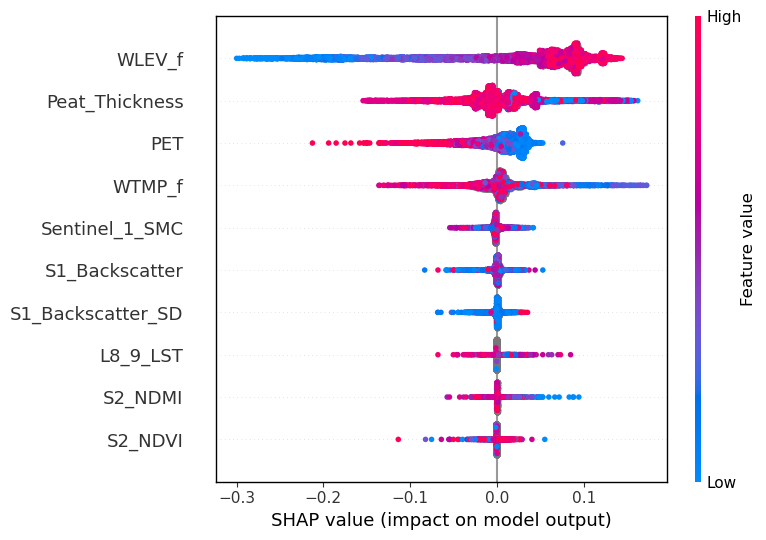

In [5]:
shap.plots.beeswarm(shap_values_explanation, show=False)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')  # Can be any color

plt.tight_layout()
#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/Beeswarm_plot.png"  
#ax.figure.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()

##### Beeswarm plot transformation which that reflects only the strength/magnitude of the impact of each feature, ignoring whether it pushes predictions higher or lower.

In [ ]:
'''
1. Ranks features by their average absolute impact
2. Features that have consistent contributions across samples will appear at the top, even if they don’t have extreme outliers
3. Is better for understanding which features have the most consistent impact.
'''
shap.plots.beeswarm(shap_values_xgb.abs)
                    #color="shap_red")

In [ ]:
'''
1. If we want to find features with high impacts we can instead sort by the max absolute value 
instead nstead of their mean absolute SHAP value (which is the default in SHAP).
2. This plot is better for identifying features that occasionally have very high influence.
'''
shap.plots.beeswarm(shap_values_xgb,
                    order=shap_values_xgb.abs.max(0))   # Computes the maximum absolute SHAP value for each feature (across all samples).

### Plot SHAP Scatter plots

Text(0.5, 1.0, 'SHAP scatter plot of GWL')

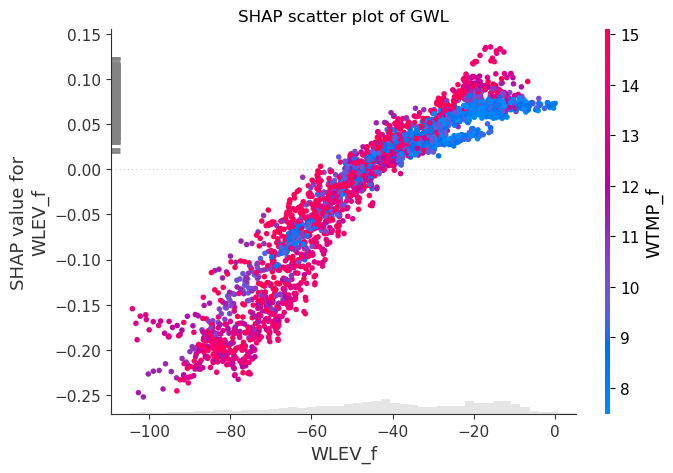

In [6]:
scatter = shap.plots.scatter(shap_values_explanation[:, 'WLEV_f'],
                             color=shap_values_explanation[:,'WTMP_f'],
                             show=False) #, xmin=15, xmax=65, ymin=-4, ymax=1.8)

plt.title("SHAP scatter plot of GWL", color="black")

### Plotting SHAP scatter plots of most influental as seen from beeswarm plot

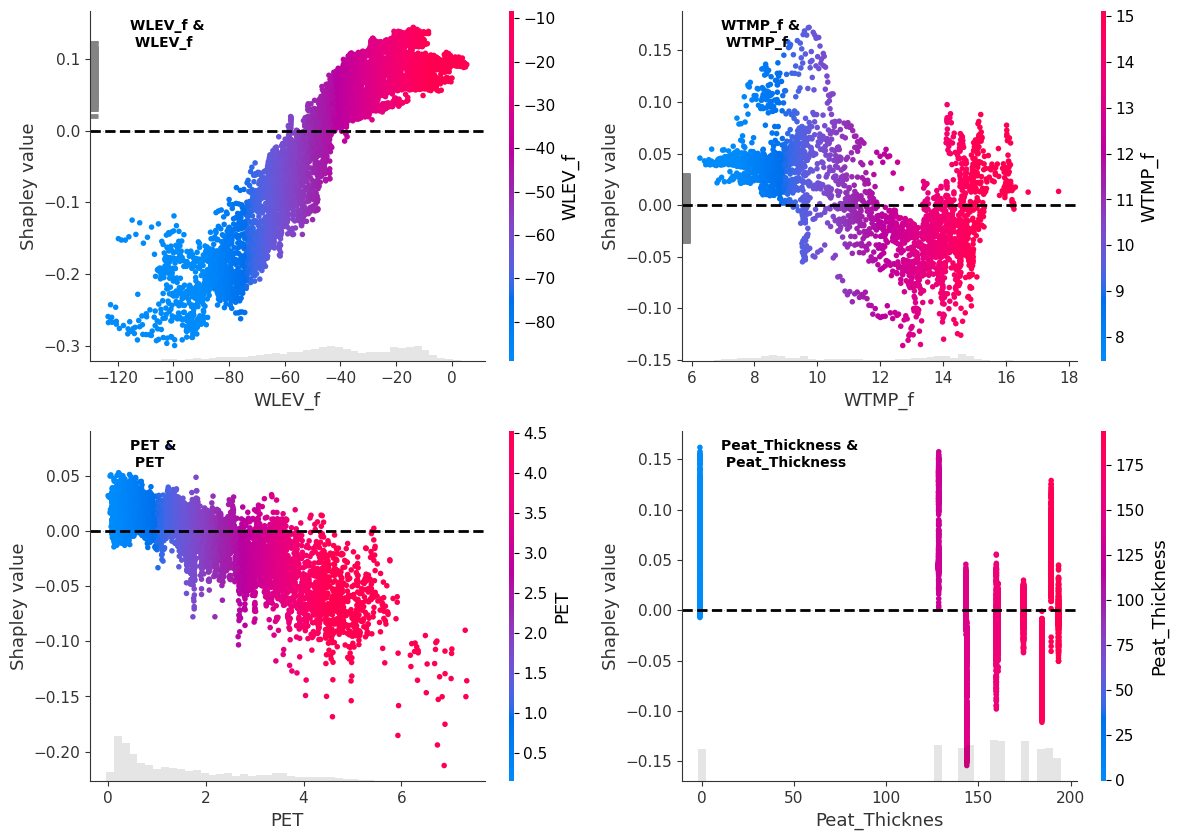

In [7]:
# Reduced figure size for better rendering
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

### AX1 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'WLEV_f'],
                   color=shap_values_explanation[:, 'WLEV_f'], 
                   show=False, ax=ax1, ylabel=None)
ax1.axhline(y=0, color='black', linewidth=2, linestyle='--')  # Horizontal line at SHAP = 0
ax1.set_ylabel('Shapley value')
ax1.set_xlabel('WLEV_f')
ax1.set_frame_on(True)
ax1.text(0.1, 0.9, 'WLEV_f &\n WLEV_f', fontdict={'fontweight': 'bold'}, transform=ax1.transAxes)

### AX2 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'WTMP_f'],
                   color=shap_values_explanation[:, 'WTMP_f'],
                   show=False, ax=ax2, ylabel=None)
ax2.axhline(y=0, color='black', linewidth=2, linestyle='--')  # Horizontal line at SHAP = 0
ax2.set_ylabel('Shapley value')
ax2.set_xlabel('WTMP_f')
ax2.set_frame_on(True)
ax2.text(0.1, 0.9, 'WTMP_f &\n WTMP_f', fontdict={'fontweight': 'bold'}, transform=ax2.transAxes)

### AX3 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'PET'],
                   color=shap_values_explanation[:, 'PET'],
                   show=False, ax=ax3, ylabel=None)
ax3.axhline(y=0, color='black', linewidth=2, linestyle='--')  # Horizontal line at SHAP = 0
ax3.set_ylabel('Shapley value')
ax3.set_xlabel('PET')
ax3.set_frame_on(True)
ax3.text(0.1, 0.9, 'PET &\n PET', fontdict={'fontweight': 'bold'}, transform=ax3.transAxes)

### AX4 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Peat_Thickness'],
                   color=shap_values_explanation[:, 'Peat_Thickness'],
                   show=False, ax=ax4, ylabel=None)
ax4.axhline(y=0, color='black', linewidth=2, linestyle='--')  # Horizontal line at SHAP = 0
ax4.set_ylabel('Shapley value')
ax4.set_xlabel('Peat_Thicknes')
ax4.set_frame_on(True)
ax4.text(0.1, 0.9, 'Peat_Thickness &\n Peat_Thickness', fontdict={'fontweight': 'bold'}, transform=ax4.transAxes)

# Show the plot
plt.show()


## SHAP scatter plots of just the remotely sensed features

Text(0.1, 0.9, 'L8_9_LST &\n L8_9_LST')

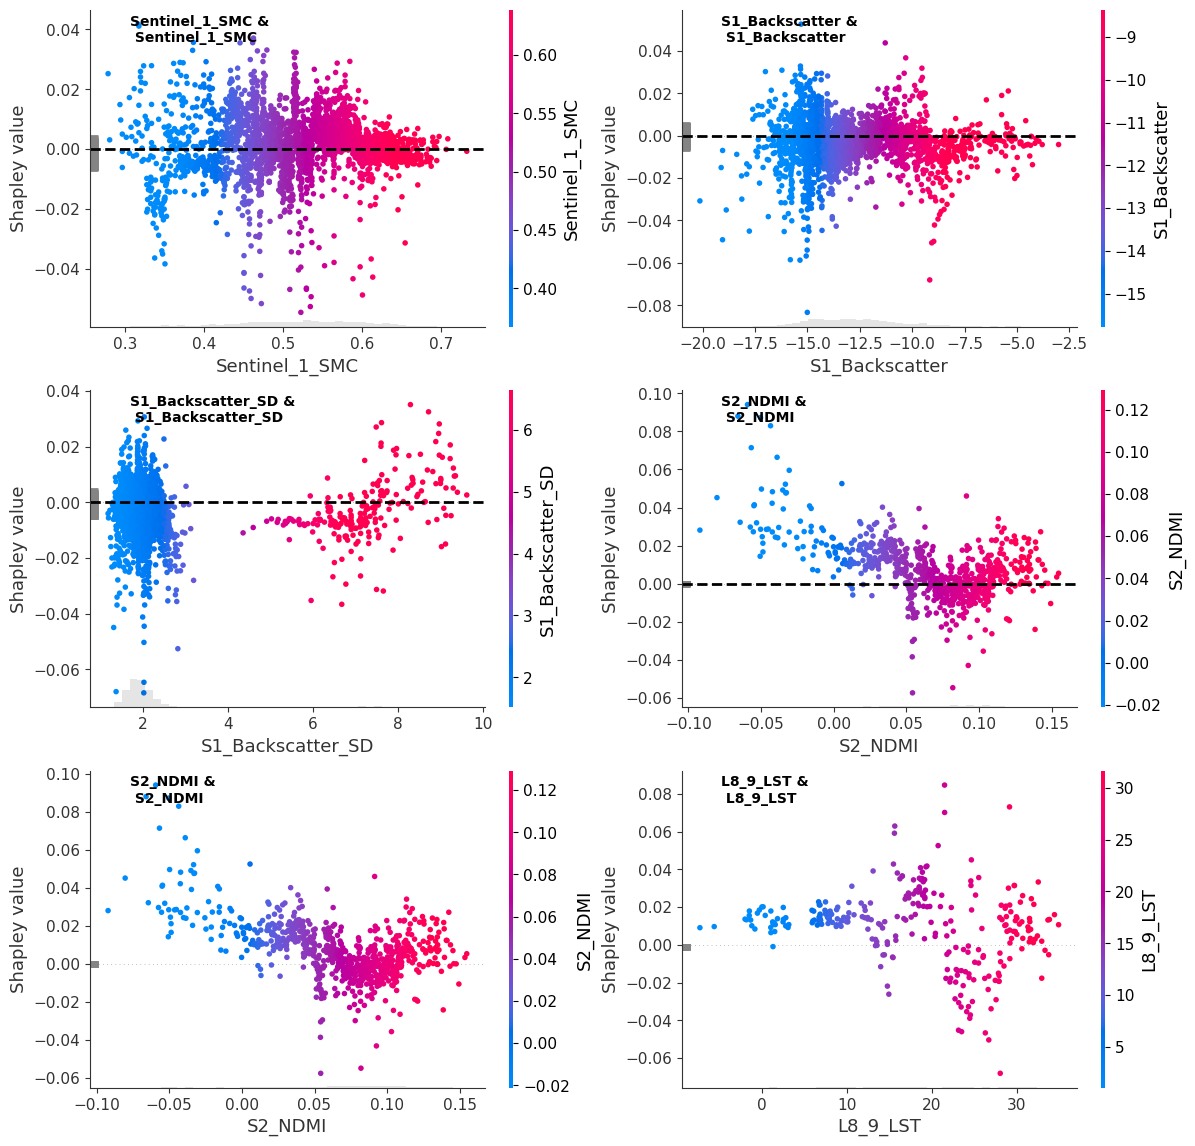

In [8]:
# Reduced figure size for better rendering
fig, ((ax1, ax2), (ax3,ax4), (ax5,ax6)) = plt.subplots(3, 2, figsize=(14, 14))

### AX1
shap.plots.scatter(shap_values_explanation[:, 'Sentinel_1_SMC'],
                   color=shap_values_explanation[:, 'Sentinel_1_SMC'], 
                   show=False,ax=ax1,ylabel=None)
ax1.axhline(y=0, color='black', linewidth=2, linestyle='--')  
ax1.set_ylabel('Shapley value')
ax1.set_xlabel('Sentinel_1_SMC')
ax1.set_frame_on(True)
ax1.text(0.1, 0.9, 'Sentinel_1_SMC &\n Sentinel_1_SMC', fontdict={'fontweight': 'bold'}, transform=ax1.transAxes)
### AX2 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S1_Backscatter'],
                   color=shap_values_explanation[:, 'S1_Backscatter'],
                   show=False,ax=ax2,ylabel=None)
ax2.axhline(y=0, color='black', linewidth=2, linestyle='--')  
ax2.set_ylabel('Shapley value')
ax2.set_xlabel('S1_Backscatter')
ax2.set_frame_on(True)
ax2.text(0.1, 0.9, 'S1_Backscatter &\n S1_Backscatter', fontdict={'fontweight': 'bold'}, transform=ax2.transAxes)
### AX3 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S1_Backscatter_SD'],
                   color=shap_values_explanation[:, 'S1_Backscatter_SD'],
                   show=False,ax=ax3,ylabel=None)
ax3.axhline(y=0, color='black', linewidth=2, linestyle='--')  
ax3.set_ylabel('Shapley value')
ax3.set_xlabel('S1_Backscatter_SD')
ax3.set_frame_on(True)
ax3.text(0.1, 0.9, 'S1_Backscatter_SD &\n S1_Backscatter_SD', fontdict={'fontweight': 'bold'}, transform=ax3.transAxes)
### AX4 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S2_NDMI'],
                   color=shap_values_explanation[:, 'S2_NDMI'],
                   show=False,ax=ax4,ylabel=None)
ax4.axhline(y=0, color='black', linewidth=2, linestyle='--')  
ax4.set_ylabel('Shapley value')
ax4.set_xlabel('S2_NDMI')
ax4.set_frame_on(True)
ax4.text(0.1, 0.9, 'S2_NDMI &\n S2_NDMI', fontdict={'fontweight': 'bold'}, transform=ax4.transAxes)
### AX5 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S2_NDMI'], 
                   color=shap_values_explanation[:, 'S2_NDMI'],
                   show=False,ax=ax5,ylabel=None)
ax5.set_ylabel('Shapley value')
ax5.set_xlabel('S2_NDMI')
ax5.set_frame_on(True)
ax5.text(0.1, 0.9, 'S2_NDMI &\n S2_NDMI', fontdict={'fontweight': 'bold'}, transform=ax5.transAxes)
### AX6 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'L8_9_LST'],
                   color=shap_values_explanation[:, 'L8_9_LST'],
                   show=False,ax=ax6,ylabel=None)
ax6.set_ylabel('Shapley value')
ax6.set_xlabel('L8_9_LST')
ax6.set_frame_on(True)
ax6.text(0.1, 0.9, 'L8_9_LST &\n L8_9_LST', fontdict={'fontweight': 'bold'}, transform=ax6.transAxes)

#plt.tight_layout()
#plt.show()

In [ ]:
# Reduced figure size for better rendering
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=(14, 10))

### AX1
shap.plots.scatter(shap_values_explanation[:, 'S1_Backscatter'],
                   color=shap_values_explanation[:, 'S1_Backscatter'], 
                   show=False,ax=ax1,ylabel=None)
ax1.axhline(y=0, color='black', linewidth=2, linestyle='--')  
ax1.set_ylabel('Shapley value')
ax1.set_xlabel('S1_Backscatter')
ax1.set_frame_on(True)
ax1.text(0.1, 0.9, 'S1_Backscatter &\n S1_Backscatter', fontdict={'fontweight': 'bold'}, transform=ax1.transAxes)
### AX2 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S2_NDVI'],
                   color=shap_values_explanation[:, 'S2_NDVI'],
                   show=False,ax=ax2,ylabel=None)
ax2.axhline(y=0, color='black', linewidth=2, linestyle='--')  
ax2.set_ylabel('Shapley value')
ax2.set_xlabel('S2_NDVI')
ax2.set_frame_on(True)
ax2.text(0.1, 0.9, 'S2_NDVI &\n S2_NDVI', fontdict={'fontweight': 'bold'}, transform=ax2.transAxes)
### AX3 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S2_EVI'],
                   color=shap_values_explanation[:, 'S2_EVI'],
                   show=False,ax=ax3,ylabel=None)
ax3.axhline(y=0, color='black', linewidth=2, linestyle='--')  
ax3.set_ylabel('Shapley value')
ax3.set_xlabel('S2_EVI')
ax3.set_frame_on(True)
ax3.text(0.1, 0.9, 'S2_EVI &\n S2_EVI', fontdict={'fontweight': 'bold'}, transform=ax3.transAxes)
### AX4 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'S2_NDMI'],
                   color=shap_values_explanation[:, 'S2_NDMI'],
                   show=False,ax=ax4,ylabel=None)
ax4.axhline(y=0, color='black', linewidth=2, linestyle='--')  
ax4.set_ylabel('Shapley value')
ax4.set_xlabel('S2_NDMI')
ax4.set_frame_on(True)
ax4.text(0.1, 0.9, 'S2_NDMI &\n S2_NDMI', fontdict={'fontweight': 'bold'}, transform=ax4.transAxes)
### AX5 ------------------------------------------------------------------------------------------------------------------
#shap.plots.scatter(shap_values_explanation[:, 'STMP_1_015'], 
#                   color=shap_values_explanation[:, 'STMP_1_015'],
#                   show=False,ax=ax5,ylabel=None)
#ax5.set_ylabel('Shapley value')
#ax5.set_xlabel('STMP_1_015')
#ax5.set_frame_on(True)
#ax5.text(0.1, 0.9, 'STMP_1_015 &\n STMP_1_015', fontdict={'fontweight': 'bold'}, transform=ax5.transAxes)
### AX6 ------------------------------------------------------------------------------------------------------------------
#shap.plots.scatter(shap_values_explanation[:, 'S1_Backscatter'],
#                   color=shap_values_explanation[:, 'S2_NDVI'],
#                   show=False,ax=ax6,ylabel=None)
#ax6.set_ylabel('Shapley value')
#ax6.set_xlabel('S1_Backscatter')
#ax6.set_frame_on(True)
#ax6.text(0.1, 0.9, 'S1_Backscatter &\n S2_NDVI', fontdict={'fontweight': 'bold'}, transform=ax6.transAxes)

#plt.tight_layout()
#plt.show()

## SHAP scatter plots of just the ground sensed features

In [ ]:
# Reduced figure size for better rendering
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6) ,(ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(16, 10))

### AX1
shap.plots.scatter(shap_values_explanation[:, 'STMP_1_015'],
                   color=shap_values_explanation[:, 'STMP_1_015'], 
                   show=False,ax=ax1,ylabel=None)
ax1.axhline(y=0, color='black', linewidth=2, linestyle='--')  
ax1.set_ylabel('Shapley value')
ax1.set_xlabel('STMP_1_015')
ax1.set_frame_on(True)
ax1.text(0.1, 0.9, 'STMP_1_015 &\n STMP_1_015', fontdict={'fontweight': 'bold'}, transform=ax1.transAxes)
### AX2 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'ATMP_f'],
                   color=shap_values_explanation[:, 'ATMP_f'],
                   show=False,ax=ax2,ylabel=None)
ax2.axhline(y=0, color='black', linewidth=2, linestyle='--')  
ax2.set_ylabel('Shapley value')
ax2.set_xlabel('ATMP_f')
ax2.set_frame_on(True)
ax2.text(0.1, 0.9, 'ATMP_f &\n ATMP_f', fontdict={'fontweight': 'bold'}, transform=ax2.transAxes)
### AX3 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'WTMP_f'],
                   color=shap_values_explanation[:, 'WTMP_f'],
                   show=False,ax=ax3,ylabel=None)
ax3.axhline(y=0, color='black', linewidth=2, linestyle='--')  
ax3.set_ylabel('Shapley value')
ax3.set_xlabel('WTMP_f')
ax3.set_frame_on(True)
ax3.text(0.1, 0.9, 'WTMP_f &\n WTMP_f', fontdict={'fontweight': 'bold'}, transform=ax3.transAxes)
### AX4 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'WLEV_f'],
                   color=shap_values_explanation[:, 'WLEV_f'],
                   show=False,ax=ax4,ylabel=None)
ax4.axhline(y=0, color='black', linewidth=2, linestyle='--')  
ax4.set_ylabel('Shapley value')
ax4.set_xlabel('WLEV_f')
ax4.set_frame_on(True)
ax4.text(0.1, 0.9, 'WLEV_f &\n WLEV_f', fontdict={'fontweight': 'bold'}, transform=ax4.transAxes)
### AX5 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'VPD_f'], 
                   color=shap_values_explanation[:, 'VPD_f'],
                   show=False,ax=ax5,ylabel=None)
ax5.axhline(y=0, color='black', linewidth=2, linestyle='--')  
ax5.set_ylabel('Shapley value')
ax5.set_xlabel('VPD_f')
ax5.set_frame_on(True)
ax5.text(0.1, 0.9, 'VPD_f &\n VPD_f', fontdict={'fontweight': 'bold'}, transform=ax5.transAxes)
### AX6 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'NEE_CO2_kg_day_ha_DAv_NT'],
                   color=shap_values_explanation[:, 'NEE_CO2_kg_day_ha_DAv_NT'],
                   show=False,ax=ax6,ylabel=None)
ax6.axhline(y=0, color='black', linewidth=2, linestyle='--')  
ax6.set_ylabel('Shapley value')
ax6.set_xlabel('NEE_CO2_kg_day_ha_DAv_NT')
ax6.set_frame_on(True)
ax6.text(0.1, 0.9, 'NEE_CO2_kg_day_ha_DAv_NT &\n NEE_CO2_kg_day_ha_DAv_NT', fontdict={'fontweight': 'bold'}, transform=ax6.transAxes)
### AX7 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'NEE_CH4_kg_day_ha_DAv_NT'],
                   color=shap_values_explanation[:, 'NEE_CH4_kg_day_ha_DAv_NT'],
                   show=False,ax=ax7,ylabel=None)
ax7.axhline(y=0, color='black', linewidth=2, linestyle='--')  
ax7.set_ylabel('Shapley value')
ax7.set_xlabel('NEE_CH4_kg_day_ha_DAv_NT')
ax7.set_frame_on(True)
ax7.text(0.1, 0.9, 'NEE_CH4_kg_day_ha_DAv_NT &\n S2_NDVI', fontdict={'fontweight': 'bold'}, transform=ax7.transAxes)
### AX8 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'BD_0_5_values'],
                   color=shap_values_explanation[:, 'BD_0_5_values'],
                   show=False,ax=ax8,ylabel=None)
ax8.axhline(y=0, color='black', linewidth=2, linestyle='--')  
ax8.set_ylabel('Shapley value')
ax8.set_xlabel('BD_0_5_values')
ax8.set_frame_on(True)
ax8.text(0.1, 0.9, 'BD_0_5_values &\n BD_0_5_values', fontdict={'fontweight': 'bold'}, transform=ax8.transAxes)
### AX9 ------------------------------------------------------------------------------------------------------------------
shap.plots.scatter(shap_values_explanation[:, 'Peat_Thickness_2022'],
                   color=shap_values_explanation[:, 'Peat_Thickness_2022'],
                   show=False,ax=ax9,ylabel=None)
ax9.axhline(y=0, color='black', linewidth=2, linestyle='--')  
ax9.set_ylabel('Shapley value')
ax9.set_xlabel('Peat_Thickness_2022')
ax9.set_frame_on(True)
ax9.text(0.1, 0.9, 'Peat_Thickness_2022 &\n Peat_Thickness_2022', fontdict={'fontweight': 'bold'}, transform=ax9.transAxes)

plt.tight_layout()
plt.show()

### Plotting heatmap 

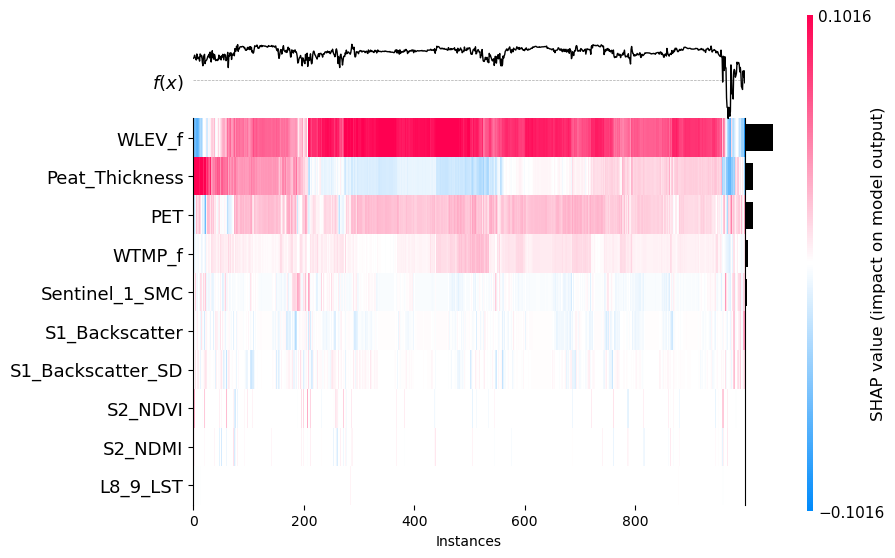

<Axes: xlabel='Instances'>

In [17]:
shap.plots.heatmap(shap_values_xgb[:1000],  # shows the SHAP values for the first 1000 instances
                   max_display=10)          # display all the features

### Plot bar plots of SHAP values

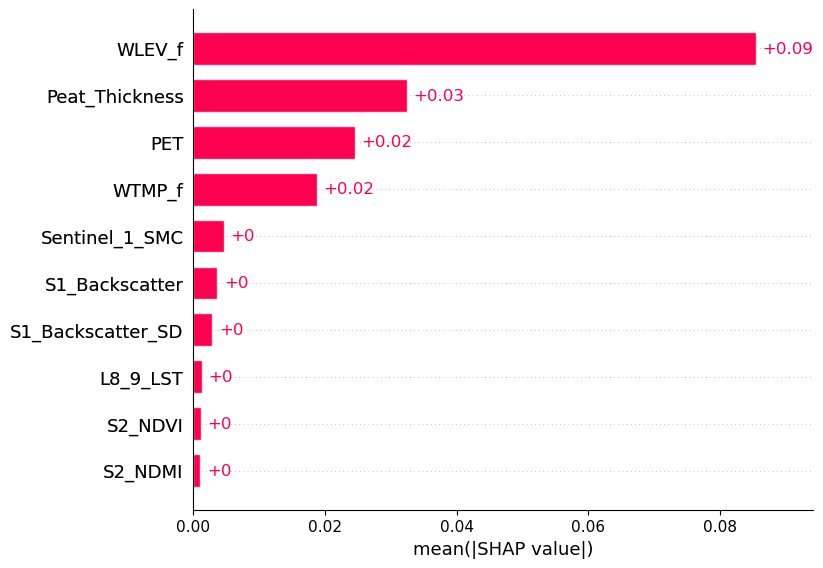

In [18]:
shap.plots.bar(shap_values_xgb,max_display=30)

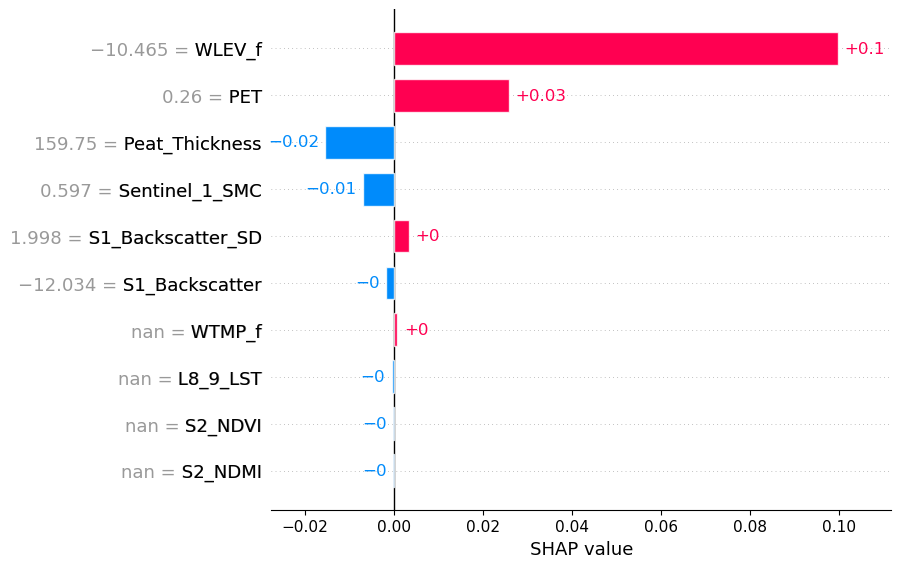

In [19]:
""" 
Passing a row of SHAP values to the bar plot function creates a local feature importance plot, 
where the bars are the SHAP values for each feature. 
Note that the feature values are show in gray to the left of the feature names.
"""
shap.plots.bar(shap_values_xgb[500])